# U-Net


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        # define forward operation using the layers we have defined
        x = self.relu(self.bn(self.conv(x)))
        return x

# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool2d((2, 2)) # use nn.MaxPool2d( )
        
    def forward(self, x):
        x = self.down(x)
        
        return x


# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')  # use nn.Upsample() with mode bilinear

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size. 
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)   
        # Then you perform upsample to x1, you will get new_x1(24 by 24)
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x1,x2), dim=1)
        
        return x


# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        x = self.conv(x)
        
        return x


In [5]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv1=single_conv(n_channels_in,16)
        self.down=down()
        self.up=up()
        self.conv2=single_conv(16,32)
        self.conv3=single_conv(32,32)
        self.conv4=single_conv(64,16)
        self.conv5=single_conv(32,16)
        self.outconv=outconv(16,n_channels_out)


    def forward(self, x):
        # Define forward pass
        x0=self.conv1(x)
        x1=self.down(x0)
        x1=self.conv2(x1)
        x2=self.down(x1)
        x2=self.conv3(x2)
        x3=self.up(x2,x1)
        x3=self.conv4(x3)
        x=self.up(x3,x0)
        x=self.conv5(x)
        x=self.outconv(x)
        
        return x
    

In [6]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [7]:
train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [8]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

In [9]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = UNet(4,5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down): down(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (up): up(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True,

In [10]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_1'):
    os.mkdir('Model_1')
model_save_path = 'Model_1/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

[                                                                        ]N/A% 

Starting epoch 1/100.


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[**                                                                      ]  4% 

0.0000 --- loss: 1.714997


[******************                                                      ] 26% 

0.2000 --- loss: 1.454328


[*********************************                                       ] 46% 

0.4000 --- loss: 1.304926


[************************************************                        ] 66% 

0.6000 --- loss: 1.216767


[************************************************************            ] 83% 

0.8000 --- loss: 1.142623


[*********************************************************               ] 79% 

Epoch finished ! Loss: 1.3199620246887207
Validation Cross-Entropy Coeff: 1.1007887125015259

[**                                                                      ]  4% 


Checkpoint 1 saved !
Starting epoch 2/100.
0.0000 --- loss: 1.075454


[******************                                                      ] 26% 

0.2000 --- loss: 1.052687


[*********************************                                       ] 46% 

0.4000 --- loss: 0.943110


[************************************************                        ] 66% 

0.6000 --- loss: 0.944588


[************************************************************            ] 83% 

0.8000 --- loss: 0.911743


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.9801424741744995
Validation Cross-Entropy Coeff: 0.8889914751052856


[**                                                                      ]  4% 

Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 0.867979


[******************                                                      ] 26% 

0.2000 --- loss: 0.894537


[*******************************                                         ] 43% 

0.4000 --- loss: 0.882211


[************************************************                        ] 66% 

0.6000 --- loss: 0.784740


[**************************************************************          ] 86% 

0.8000 --- loss: 0.782957


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.8518011569976807
Validation Cross-Entropy Coeff: 0.7969971895217896


[*                                                                       ]  2% 

Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.759290


[******************                                                      ] 26% 

0.2000 --- loss: 0.752674


[*******************************                                         ] 43% 

0.4000 --- loss: 0.712247


[************************************************                        ] 66% 

0.6000 --- loss: 0.764558


[**************************************************************          ] 86% 

0.8000 --- loss: 0.773907


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.7854894995689392


[****                                                                    ]  6% 

Validation Cross-Entropy Coeff: 0.7431592345237732
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.814398


[******************                                                      ] 26% 

0.2000 --- loss: 0.703406


[*******************************                                         ] 43% 

0.4000 --- loss: 0.712481


[************************************************                        ] 66% 

0.6000 --- loss: 0.754508


[**************************************************************          ] 86% 

0.8000 --- loss: 0.740815


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.7453395128250122
Validation Cross-Entropy Coeff: 0.7104302644729614

[*                                                                       ]  2% 


Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.779472


[****************                                                        ] 23% 

0.2000 --- loss: 0.712214


[*********************************                                       ] 46% 

0.4000 --- loss: 0.606064


[************************************************                        ] 66% 

0.6000 --- loss: 0.684739


[************************************************************            ] 83% 

0.8000 --- loss: 0.686587


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.7135264873504639


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.6779893636703491
Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.692071


[******************                                                      ] 26% 

0.2000 --- loss: 0.595500


[*******************************                                         ] 43% 

0.4000 --- loss: 0.746592


[************************************************                        ] 66% 

0.6000 --- loss: 0.690589


[**************************************************************          ] 86% 

0.8000 --- loss: 0.645689


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6908125281333923


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.6569573283195496
Checkpoint 7 saved !
Starting epoch 8/100.
0.0000 --- loss: 0.694012


[******************                                                      ] 26% 

0.2000 --- loss: 0.718890


[*********************************                                       ] 46% 

0.4000 --- loss: 0.646182


[************************************************                        ] 66% 

0.6000 --- loss: 0.678801


[**************************************************************          ] 86% 

0.8000 --- loss: 0.576907


[************************************************                        ] 66% 

Epoch finished ! Loss: 0.6762097477912903


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.6409419178962708
Checkpoint 8 saved !
Starting epoch 9/100.
0.0000 --- loss: 0.653318


[******************                                                      ] 26% 

0.2000 --- loss: 0.737619


[*********************************                                       ] 46% 

0.4000 --- loss: 0.651976


[************************************************                        ] 66% 

0.6000 --- loss: 0.580645


[**************************************************************          ] 86% 

0.8000 --- loss: 0.643656


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6612525582313538


[*****                                                                   ]  7% 

Validation Cross-Entropy Coeff: 0.6359677910804749
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.657331


[****************                                                        ] 23% 

0.2000 --- loss: 0.628102


[**********************************                                      ] 48% 

0.4000 --- loss: 0.588158


[************************************************                        ] 66% 

0.6000 --- loss: 0.628864


[**************************************************************          ] 86% 

0.8000 --- loss: 0.645826


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6475940346717834
Validation Cross-Entropy Coeff: 0.619973361492157

[**                                                                      ]  4% 


Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.582283


[******************                                                      ] 26% 

0.2000 --- loss: 0.552399


[*********************************                                       ] 46% 

0.4000 --- loss: 0.641665


[************************************************                        ] 66% 

0.6000 --- loss: 0.707963


[**************************************************************          ] 86% 

0.8000 --- loss: 0.649232


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.6394162178039551
Validation Cross-Entropy Coeff: 0.6128473877906799


[****                                                                    ]  6% 

Checkpoint 11 saved !
Starting epoch 12/100.
0.0000 --- loss: 0.649092


[****************                                                        ] 23% 

0.2000 --- loss: 0.575808


[*********************************                                       ] 46% 

0.4000 --- loss: 0.639358


[*********************************************                           ] 63% 

0.6000 --- loss: 0.659584


[**************************************************************          ] 86% 

0.8000 --- loss: 0.726691


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6349251866340637
Validation Cross-Entropy Coeff: 0.6037279367446899

[**                                                                      ]  4% 


Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.555780


[******************                                                      ] 26% 

0.2000 --- loss: 0.694822


[**********************************                                      ] 47% 

0.4000 --- loss: 0.633722


[************************************************                        ] 66% 

0.6000 --- loss: 0.644891


[**************************************************************          ] 86% 

0.8000 --- loss: 0.808831


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.6230694055557251


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.6004147529602051
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.662307


[******************                                                      ] 26% 

0.2000 --- loss: 0.645420


[*********************************                                       ] 46% 

0.4000 --- loss: 0.720579


[*********************************************                           ] 63% 

0.6000 --- loss: 0.657054


[************************************************************            ] 83% 

0.8000 --- loss: 0.685576


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6219679713249207
Validation Cross-Entropy Coeff: 0.5984001159667969


[**                                                                      ]  4% 

Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.540681


[******************                                                      ] 26% 

0.2000 --- loss: 0.595647


[*******************************                                         ] 43% 

0.4000 --- loss: 0.634288


[************************************************                        ] 66% 

0.6000 --- loss: 0.580212


[**************************************************************          ] 86% 

0.8000 --- loss: 0.604756


[************************************************                        ] 66% 

Epoch finished ! Loss: 0.6155735850334167


[*                                                                       ]  2% 

Validation Cross-Entropy Coeff: 0.5882989168167114
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.581162


[****************                                                        ] 23% 

0.2000 --- loss: 0.621043


[*********************************                                       ] 46% 

0.4000 --- loss: 0.620167


[*********************************************                           ] 63% 

0.6000 --- loss: 0.623005


[**************************************************************          ] 86% 

0.8000 --- loss: 0.731534


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.6109554171562195
Validation Cross-Entropy Coeff: 0.5969420671463013

[**                                                                      ]  4% 


Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.645505


[******************                                                      ] 26% 

0.2000 --- loss: 0.665604


[*******************************                                         ] 43% 

0.4000 --- loss: 0.583194


[************************************************                        ] 66% 

0.6000 --- loss: 0.548022


[************************************************************            ] 83% 

0.8000 --- loss: 0.558189


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.6112697720527649


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5827934741973877
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.610754


[*******************                                                     ] 27% 

0.2000 --- loss: 0.544748


[*******************************                                         ] 43% 

0.4000 --- loss: 0.562645


[************************************************                        ] 66% 

0.6000 --- loss: 0.683767


[**************************************************************          ] 86% 

0.8000 --- loss: 0.568621


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.600748598575592
Validation Cross-Entropy Coeff: 0.5824772119522095

[****                                                                    ]  6% 


Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.512970


[******************                                                      ] 26% 

0.2000 --- loss: 0.584285


[*********************************                                       ] 46% 

0.4000 --- loss: 0.624628


[*********************************************                           ] 63% 

0.6000 --- loss: 0.698326


[**************************************************************          ] 86% 

0.8000 --- loss: 0.586581


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5982422828674316


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5755355358123779
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.536666


[******************                                                      ] 26% 

0.2000 --- loss: 0.486748


[*********************************                                       ] 46% 

0.4000 --- loss: 0.628527


[************************************************                        ] 66% 

0.6000 --- loss: 0.594248


[**************************************************************          ] 86% 

0.8000 --- loss: 0.602106


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.592876136302948
Validation Cross-Entropy Coeff: 0.5694132447242737

[****                                                                    ]  6% 


Checkpoint 20 saved !
Starting epoch 21/100.
0.0000 --- loss: 0.532764


[******************                                                      ] 26% 

0.2000 --- loss: 0.555701


[**********************************                                      ] 47% 

0.4000 --- loss: 0.609366


[**********************************************                          ] 64% 

0.6000 --- loss: 0.584168


[************************************************************            ] 83% 

0.8000 --- loss: 0.553164


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5907571911811829


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5708426833152771
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.638601


[******************                                                      ] 26% 

0.2000 --- loss: 0.547684


[*******************************                                         ] 43% 

0.4000 --- loss: 0.630694


[************************************************                        ] 66% 

0.6000 --- loss: 0.540444


[**************************************************************          ] 86% 

0.8000 --- loss: 0.515579


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5883075594902039
Validation Cross-Entropy Coeff: 0.5753865242004395


[**                                                                      ]  4% 

Checkpoint 22 saved !
Starting epoch 23/100.
0.0000 --- loss: 0.597918


[******************                                                      ] 26% 

0.2000 --- loss: 0.533437


[*********************************                                       ] 46% 

0.4000 --- loss: 0.585411


[************************************************                        ] 66% 

0.6000 --- loss: 0.580569


[**************************************************************          ] 86% 

0.8000 --- loss: 0.498853


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5850521922111511
Validation Cross-Entropy Coeff: 0.56345534324646

[**                                                                      ]  4% 


Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.523195


[******************                                                      ] 26% 

0.2000 --- loss: 0.569764


[*********************************                                       ] 46% 

0.4000 --- loss: 0.559225


[************************************************                        ] 66% 

0.6000 --- loss: 0.685686


[**************************************************************          ] 86% 

0.8000 --- loss: 0.441092


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5840439200401306
Validation Cross-Entropy Coeff: 0.5699933767318726

[**                                                                      ]  4% 


Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.567434


[******************                                                      ] 26% 

0.2000 --- loss: 0.526137


[*********************************                                       ] 46% 

0.4000 --- loss: 0.576592


[************************************************                        ] 66% 

0.6000 --- loss: 0.704155


[**************************************************************          ] 86% 

0.8000 --- loss: 0.589771


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5820425748825073
Validation Cross-Entropy Coeff: 0.559226393699646


[****                                                                    ]  6% 

Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.538544


[****************                                                        ] 23% 

0.2000 --- loss: 0.590724


[*******************************                                         ] 43% 

0.4000 --- loss: 0.611389


[*********************************************                           ] 63% 

0.6000 --- loss: 0.486832


[**************************************************************          ] 86% 

0.8000 --- loss: 0.571193


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5802116394042969
Validation Cross-Entropy Coeff: 0.5613853931427002

[**                                                                      ]  4% 


Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.634409


[******************                                                      ] 26% 

0.2000 --- loss: 0.574932


[*********************************                                       ] 46% 

0.4000 --- loss: 0.582565


[*********************************************                           ] 63% 

0.6000 --- loss: 0.567940


[**************************************************************          ] 86% 

0.8000 --- loss: 0.504391


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.580299437046051


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5567662119865417
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.573273


[****************                                                        ] 23% 

0.2000 --- loss: 0.501905


[**********************************                                      ] 47% 

0.4000 --- loss: 0.494693


[************************************************                        ] 66% 

0.6000 --- loss: 0.565413


[**************************************************************          ] 86% 

0.8000 --- loss: 0.560923


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.572716236114502
Validation Cross-Entropy Coeff: 0.5540398359298706

[**                                                                      ]  4% 


Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.631018


[******************                                                      ] 26% 

0.2000 --- loss: 0.629652


[*********************************                                       ] 46% 

0.4000 --- loss: 0.611102


[************************************************                        ] 66% 

0.6000 --- loss: 0.565752


[**************************************************************          ] 86% 

0.8000 --- loss: 0.540758


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5724959969520569


[****                                                                    ]  6% 

Validation Cross-Entropy Coeff: 0.5491219162940979
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.494568


[****************                                                        ] 23% 

0.2000 --- loss: 0.510923


[*********************************                                       ] 46% 

0.4000 --- loss: 0.711725


[************************************************                        ] 66% 

0.6000 --- loss: 0.596506


[**************************************************************          ] 86% 

0.8000 --- loss: 0.543283


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5704041719436646


[****                                                                    ]  6% 

Validation Cross-Entropy Coeff: 0.5492502450942993
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.654361


[******************                                                      ] 26% 

0.2000 --- loss: 0.586612


[*********************************                                       ] 46% 

0.4000 --- loss: 0.611889


[************************************************                        ] 66% 

0.6000 --- loss: 0.595082


[**************************************************************          ] 86% 

0.8000 --- loss: 0.530324


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5711288452148438
Validation Cross-Entropy Coeff: 0.5516459941864014


Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.593769


[******************                                                      ] 26% 

0.2000 --- loss: 0.512014


[*******************************                                         ] 43% 

0.4000 --- loss: 0.610574


[************************************************                        ] 66% 

0.6000 --- loss: 0.671095


[***************************************************************         ] 87% 

0.8000 --- loss: 0.657094


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.572106122970581
Validation Cross-Entropy Coeff: 0.5561566352844238


[**                                                                      ]  4% 

Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.548603


[******************                                                      ] 26% 

0.2000 --- loss: 0.534594


[*********************************                                       ] 46% 

0.4000 --- loss: 0.580994


[*********************************************                           ] 63% 

0.6000 --- loss: 0.532905


[************************************************************            ] 83% 

0.8000 --- loss: 0.534450


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5651121735572815


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5686101913452148
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.626229


[****************                                                        ] 23% 

0.2000 --- loss: 0.541074


[**********************************                                      ] 47% 

0.4000 --- loss: 0.581418


[************************************************                        ] 66% 

0.6000 --- loss: 0.530454


[**************************************************************          ] 86% 

0.8000 --- loss: 0.468784


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5677263736724854
Validation Cross-Entropy Coeff: 0.5405614376068115


[**                                                                      ]  4% 

Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.554156


[****************                                                        ] 23% 

0.2000 --- loss: 0.580319


[*********************************                                       ] 46% 

0.4000 --- loss: 0.573511


[*********************************************                           ] 63% 

0.6000 --- loss: 0.501664


[**************************************************************          ] 86% 

0.8000 --- loss: 0.571343


[***************************************************                     ] 70% 

Epoch finished ! Loss: 0.5643599629402161


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5541882514953613
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.510081


[****************                                                        ] 23% 

0.2000 --- loss: 0.563108


[*******************************                                         ] 43% 

0.4000 --- loss: 0.588369


[*********************************************                           ] 63% 

0.6000 --- loss: 0.682776


[**************************************************************          ] 86% 

0.8000 --- loss: 0.546905


[*********************************************************************   ] 95% 

Epoch finished ! Loss: 0.5657544136047363
Validation Cross-Entropy Coeff: 0.5444808602333069

[**                                                                      ]  4% 


Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.667029


[******************                                                      ] 26% 

0.2000 --- loss: 0.609652


[*******************************                                         ] 43% 

0.4000 --- loss: 0.664987


[*********************************************                           ] 63% 

0.6000 --- loss: 0.688362


[**************************************************************          ] 86% 

0.8000 --- loss: 0.485112


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.561683177947998
Validation Cross-Entropy Coeff: 0.5360099673271179

[**                                                                      ]  4% 


Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.527385


[****************                                                        ] 23% 

0.2000 --- loss: 0.490083


[*********************************                                       ] 46% 

0.4000 --- loss: 0.469243


[************************************************                        ] 66% 

0.6000 --- loss: 0.614266


[************************************************************            ] 83% 

0.8000 --- loss: 0.545223


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5601029396057129
Validation Cross-Entropy Coeff: 0.5433590412139893

[**                                                                      ]  4% 


Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.478659


[******************                                                      ] 26% 

0.2000 --- loss: 0.506752


[*********************************                                       ] 46% 

0.4000 --- loss: 0.536987


[*********************************************                           ] 63% 

0.6000 --- loss: 0.498615


[************************************************************            ] 83% 

0.8000 --- loss: 0.660802


[***************************************************                     ] 70% 

Epoch finished ! Loss: 0.560221254825592


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5351914763450623
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.653961


[****************                                                        ] 23% 

0.2000 --- loss: 0.588927


[*********************************                                       ] 46% 

0.4000 --- loss: 0.466990


[*********************************************                           ] 63% 

0.6000 --- loss: 0.631629


[****************************************************************        ] 89% 

0.8000 --- loss: 0.594988


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5584694147109985


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5353715419769287
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.544702


[****************                                                        ] 23% 

0.2000 --- loss: 0.551549


[*********************************                                       ] 46% 

0.4000 --- loss: 0.566999


[*********************************************                           ] 63% 

0.6000 --- loss: 0.568162


[**************************************************************          ] 86% 

0.8000 --- loss: 0.514162


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5570029020309448
Validation Cross-Entropy Coeff: 0.5396162867546082

[**                                                                      ]  4% 


Checkpoint 41 saved !
Starting epoch 42/100.
0.0000 --- loss: 0.544604


[****************                                                        ] 23% 

0.2000 --- loss: 0.591092


[*********************************                                       ] 46% 

0.4000 --- loss: 0.617080


[*********************************************                           ] 63% 

0.6000 --- loss: 0.554647


[**************************************************************          ] 86% 

0.8000 --- loss: 0.561349


[******************************************************************      ] 91% 

Epoch finished ! Loss: 0.556414008140564
Validation Cross-Entropy Coeff: 0.5435950756072998


[****                                                                    ]  6% 

Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.472580


[******************                                                      ] 26% 

0.2000 --- loss: 0.534796


[*********************************                                       ] 46% 

0.4000 --- loss: 0.579745


[*********************************************                           ] 63% 

0.6000 --- loss: 0.567159


[************************************************************            ] 83% 

0.8000 --- loss: 0.548173


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5526105761528015
Validation Cross-Entropy Coeff: 0.5364543795585632


[****                                                                    ]  6% 

Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.480329


[******************                                                      ] 26% 

0.2000 --- loss: 0.620329


[*******************************                                         ] 43% 

0.4000 --- loss: 0.541573


[*********************************************                           ] 63% 

0.6000 --- loss: 0.496005


[************************************************************            ] 83% 

0.8000 --- loss: 0.659302


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5536767244338989
Validation Cross-Entropy Coeff: 0.5405634641647339

[**                                                                      ]  4% 


Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.544621


[******************                                                      ] 26% 

0.2000 --- loss: 0.551199


[*********************************                                       ] 46% 

0.4000 --- loss: 0.479875


[*********************************************                           ] 63% 

0.6000 --- loss: 0.555364


[**************************************************************          ] 86% 

0.8000 --- loss: 0.615980


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5500427484512329
Validation Cross-Entropy Coeff: 0.5479191541671753

[**                                                                      ]  4% 


Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.588644


[****************                                                        ] 23% 

0.2000 --- loss: 0.548806


[*******************************                                         ] 43% 

0.4000 --- loss: 0.595508


[************************************************                        ] 66% 

0.6000 --- loss: 0.555605


[************************************************************            ] 83% 

0.8000 --- loss: 0.494115


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5476981401443481
Validation Cross-Entropy Coeff: 0.5332605838775635


Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.539374


[******************                                                      ] 26% 

0.2000 --- loss: 0.590048


[*********************************                                       ] 46% 

0.4000 --- loss: 0.505104


[************************************************                        ] 66% 

0.6000 --- loss: 0.536193


[************************************************************            ] 83% 

0.8000 --- loss: 0.649386


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5501381754875183


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5465793609619141
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.509112


[****************                                                        ] 23% 

0.2000 --- loss: 0.519835


[*******************************                                         ] 43% 

0.4000 --- loss: 0.464236


[*********************************************                           ] 63% 

0.6000 --- loss: 0.534671


[************************************************************            ] 83% 

0.8000 --- loss: 0.471774


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5433142781257629


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5411110520362854
Checkpoint 48 saved !
Starting epoch 49/100.
0.0000 --- loss: 0.526908


[****************                                                        ] 23% 

0.2000 --- loss: 0.461482


[*******************************                                         ] 43% 

0.4000 --- loss: 0.515812


[************************************************                        ] 67% 

0.6000 --- loss: 0.522218


[**************************************************************          ] 86% 

0.8000 --- loss: 0.483765


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5445801019668579
Validation Cross-Entropy Coeff: 0.5312932133674622


[**                                                                      ]  4% 

Checkpoint 49 saved !
Starting epoch 50/100.
0.0000 --- loss: 0.507539


[****************                                                        ] 23% 

0.2000 --- loss: 0.520052


[*********************************                                       ] 46% 

0.4000 --- loss: 0.519551


[*********************************************                           ] 63% 

0.6000 --- loss: 0.497819


[************************************************************            ] 83% 

0.8000 --- loss: 0.480966


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5461936593055725
Validation Cross-Entropy Coeff: 0.5411189198493958


[**                                                                      ]  4% 

Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.609621


[******************                                                      ] 26% 

0.2000 --- loss: 0.593465


[*********************************                                       ] 46% 

0.4000 --- loss: 0.524784


[************************************************                        ] 66% 

0.6000 --- loss: 0.588133


[**************************************************************          ] 86% 

0.8000 --- loss: 0.439313


[******************************************************************      ] 91% 

Epoch finished ! Loss: 0.5431677103042603
Validation Cross-Entropy Coeff: 0.5338437557220459


Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.496643


[****************                                                        ] 23% 

0.2000 --- loss: 0.542529


[*********************************                                       ] 46% 

0.4000 --- loss: 0.537788


[*********************************************                           ] 63% 

0.6000 --- loss: 0.531615


[************************************************************            ] 83% 

0.8000 --- loss: 0.483288


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5379055738449097
Validation Cross-Entropy Coeff: 0.5370436906814575

[**                                                                      ]  4% 


Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.638869


[******************                                                      ] 26% 

0.2000 --- loss: 0.497026


[*********************************                                       ] 46% 

0.4000 --- loss: 0.556487


[************************************************                        ] 66% 

0.6000 --- loss: 0.468015


[************************************************************            ] 83% 

0.8000 --- loss: 0.514072


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5458640456199646
Validation Cross-Entropy Coeff: 0.546165943145752


[**                                                                      ]  4% 

Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.563599


[******************                                                      ] 26% 

0.2000 --- loss: 0.515131


[*******************************                                         ] 43% 

0.4000 --- loss: 0.608466


[*********************************************                           ] 63% 

0.6000 --- loss: 0.562711


[**************************************************************          ] 86% 

0.8000 --- loss: 0.594475


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5406805276870728


[****                                                                    ]  6% 

Validation Cross-Entropy Coeff: 0.5325989127159119
Checkpoint 54 saved !
Starting epoch 55/100.
0.0000 --- loss: 0.615401


[*******************                                                     ] 27% 

0.2000 --- loss: 0.577503


[*******************************                                         ] 43% 

0.4000 --- loss: 0.509699


[************************************************                        ] 66% 

0.6000 --- loss: 0.563880


[**************************************************************          ] 86% 

0.8000 --- loss: 0.497308


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5390813946723938
Validation Cross-Entropy Coeff: 0.5319995284080505

[****                                                                    ]  6% 


Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.599137


[****************                                                        ] 23% 

0.2000 --- loss: 0.493852


[*********************************                                       ] 46% 

0.4000 --- loss: 0.562795


[************************************************                        ] 66% 

0.6000 --- loss: 0.533514


[************************************************************            ] 83% 

0.8000 --- loss: 0.423428


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5396362543106079
Validation Cross-Entropy Coeff: 0.5379428863525391

[**                                                                      ]  4% 


Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.642253


[******************                                                      ] 26% 

0.2000 --- loss: 0.530744


[*********************************                                       ] 46% 

0.4000 --- loss: 0.451835


[************************************************                        ] 66% 

0.6000 --- loss: 0.473265


[************************************************************            ] 83% 

0.8000 --- loss: 0.463032


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.539117157459259
Validation Cross-Entropy Coeff: 0.5359504222869873


[**                                                                      ]  4% 

Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.612758


[****************                                                        ] 23% 

0.2000 --- loss: 0.477318


[*******************************                                         ] 43% 

0.4000 --- loss: 0.454548


[*********************************************                           ] 63% 

0.6000 --- loss: 0.494496


[**************************************************************          ] 86% 

0.8000 --- loss: 0.479232


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5373075604438782


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5260023474693298
Checkpoint 58 saved !
Starting epoch 59/100.
0.0000 --- loss: 0.570875


[******************                                                      ] 26% 

0.2000 --- loss: 0.508730


[*********************************                                       ] 46% 

0.4000 --- loss: 0.488053


[*********************************************                           ] 63% 

0.6000 --- loss: 0.456252


[************************************************************            ] 83% 

0.8000 --- loss: 0.502164


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5368326902389526
Validation Cross-Entropy Coeff: 0.5249058604240417


[**                                                                      ]  4% 

Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.440275


[******************                                                      ] 26% 

0.2000 --- loss: 0.573467


[*********************************                                       ] 46% 

0.4000 --- loss: 0.507525


[************************************************                        ] 66% 

0.6000 --- loss: 0.553147


[**************************************************************          ] 86% 

0.8000 --- loss: 0.572191


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5342705845832825
Validation Cross-Entropy Coeff: 0.5234643220901489


[**                                                                      ]  4% 

Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.575935


[****************                                                        ] 23% 

0.2000 --- loss: 0.469348


[**********************************                                      ] 48% 

0.4000 --- loss: 0.524796


[************************************************                        ] 66% 

0.6000 --- loss: 0.531767


[**************************************************************          ] 86% 

0.8000 --- loss: 0.487083


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5343470573425293


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.534660816192627
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.461143


[******************                                                      ] 26% 

0.2000 --- loss: 0.554461


[*********************************                                       ] 46% 

0.4000 --- loss: 0.519275


[************************************************                        ] 66% 

0.6000 --- loss: 0.496287


[**************************************************************          ] 86% 

0.8000 --- loss: 0.588254


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5368330478668213
Validation Cross-Entropy Coeff: 0.5225884318351746

[****                                                                    ]  6% 


Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.598429


[****************                                                        ] 23% 

0.2000 --- loss: 0.498055


[*******************************                                         ] 43% 

0.4000 --- loss: 0.489491


[************************************************                        ] 66% 

0.6000 --- loss: 0.444543


[**************************************************************          ] 86% 

0.8000 --- loss: 0.456859


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5329098105430603
Validation Cross-Entropy Coeff: 0.5360978841781616


[**                                                                      ]  4% 

Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.492169


[******************                                                      ] 26% 

0.2000 --- loss: 0.598079


[**********************************                                      ] 48% 

0.4000 --- loss: 0.568760


[************************************************                        ] 66% 

0.6000 --- loss: 0.482836


[**************************************************************          ] 86% 

0.8000 --- loss: 0.523054


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5320175290107727
Validation Cross-Entropy Coeff: 0.5249236822128296

[**                                                                      ]  4% 


Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.546806


[****************                                                        ] 23% 

0.2000 --- loss: 0.577191


[*********************************                                       ] 46% 

0.4000 --- loss: 0.494150


[*********************************************                           ] 63% 

0.6000 --- loss: 0.373994


[**************************************************************          ] 86% 

0.8000 --- loss: 0.488994


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5297970771789551
Validation Cross-Entropy Coeff: 0.5249770879745483


[**                                                                      ]  4% 

Checkpoint 65 saved !
Starting epoch 66/100.
0.0000 --- loss: 0.558753


[******************                                                      ] 26% 

0.2000 --- loss: 0.613770


[*********************************                                       ] 46% 

0.4000 --- loss: 0.600029


[************************************************                        ] 66% 

0.6000 --- loss: 0.546153


[************************************************************            ] 83% 

0.8000 --- loss: 0.642455


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5359653234481812


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5804099440574646
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.490456


[******************                                                      ] 26% 

0.2000 --- loss: 0.460511


[*********************************                                       ] 46% 

0.4000 --- loss: 0.582776


[************************************************                        ] 66% 

0.6000 --- loss: 0.522156


[************************************************************            ] 83% 

0.8000 --- loss: 0.487635


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5326173305511475
Validation Cross-Entropy Coeff: 0.5295336842536926


[****                                                                    ]  6% 

Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.469859


[****************                                                        ] 23% 

0.2000 --- loss: 0.580976


[*********************************                                       ] 46% 

0.4000 --- loss: 0.565018


[*********************************************                           ] 63% 

0.6000 --- loss: 0.699262


[**************************************************************          ] 86% 

0.8000 --- loss: 0.552057


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5324863195419312


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5191664099693298
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.507780


[******************                                                      ] 26% 

0.2000 --- loss: 0.520107


[*********************************                                       ] 46% 

0.4000 --- loss: 0.488247


[*********************************************                           ] 63% 

0.6000 --- loss: 0.520693


[************************************************************            ] 83% 

0.8000 --- loss: 0.460796


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5270776152610779


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5233530402183533
Checkpoint 69 saved !
Starting epoch 70/100.
0.0000 --- loss: 0.574193


[******************                                                      ] 26% 

0.2000 --- loss: 0.578214


[*******************************                                         ] 43% 

0.4000 --- loss: 0.576093


[*********************************************                           ] 63% 

0.6000 --- loss: 0.467481


[**************************************************************          ] 86% 

0.8000 --- loss: 0.589349


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5330135822296143


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5493708848953247
Checkpoint 70 saved !
Starting epoch 71/100.
0.0000 --- loss: 0.444829


[******************                                                      ] 26% 

0.2000 --- loss: 0.478577


[*********************************                                       ] 46% 

0.4000 --- loss: 0.608834


[************************************************                        ] 66% 

0.6000 --- loss: 0.513450


[**************************************************************          ] 86% 

0.8000 --- loss: 0.447828


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5283244252204895


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5152500867843628
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.493418


[****************                                                        ] 23% 

0.2000 --- loss: 0.536515


[*******************************                                         ] 43% 

0.4000 --- loss: 0.431802


[************************************************                        ] 66% 

0.6000 --- loss: 0.502297


[**************************************************************          ] 86% 

0.8000 --- loss: 0.547149


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5238752961158752
Validation Cross-Entropy Coeff: 0.5167862772941589

[****                                                                    ]  6% 


Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.516827


[****************                                                        ] 23% 

0.2000 --- loss: 0.485416


[*********************************                                       ] 46% 

0.4000 --- loss: 0.588424


[*********************************************                           ] 63% 

0.6000 --- loss: 0.517628


[**************************************************************          ] 86% 

0.8000 --- loss: 0.508406


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5315277576446533
Validation Cross-Entropy Coeff: 0.5864914655685425

[**                                                                      ]  4% 


Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.564537


[****************                                                        ] 23% 

0.2000 --- loss: 0.583246


[*********************************                                       ] 46% 

0.4000 --- loss: 0.460499


[************************************************                        ] 66% 

0.6000 --- loss: 0.530756


[**************************************************************          ] 86% 

0.8000 --- loss: 0.488192


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5275127291679382
Validation Cross-Entropy Coeff: 0.5209051966667175


[****                                                                    ]  6% 

Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.464580


[****************                                                        ] 23% 

0.2000 --- loss: 0.477860


[*******************************                                         ] 43% 

0.4000 --- loss: 0.663044


[************************************************                        ] 66% 

0.6000 --- loss: 0.525161


[************************************************************            ] 83% 

0.8000 --- loss: 0.531141


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5270101428031921


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5262107849121094
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.537715


[******************                                                      ] 26% 

0.2000 --- loss: 0.549609


[*********************************                                       ] 46% 

0.4000 --- loss: 0.555458


[*********************************************                           ] 63% 

0.6000 --- loss: 0.490494


[************************************************************            ] 83% 

0.8000 --- loss: 0.461072


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5275986194610596


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5103086829185486
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.447933


[******************                                                      ] 26% 

0.2000 --- loss: 0.446317


[*******************************                                         ] 43% 

0.4000 --- loss: 0.560117


[*********************************************                           ] 63% 

0.6000 --- loss: 0.544285


[************************************************************            ] 83% 

0.8000 --- loss: 0.551490


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5212703943252563


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5363767147064209
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.489426


[****************                                                        ] 23% 

0.2000 --- loss: 0.531006


[*********************************                                       ] 46% 

0.4000 --- loss: 0.463524


[*********************************************                           ] 63% 

0.6000 --- loss: 0.452079


[************************************************************            ] 83% 

0.8000 --- loss: 0.469764


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5222761631011963
Validation Cross-Entropy Coeff: 0.5271486043930054

[**                                                                      ]  4% 


Checkpoint 78 saved !
Starting epoch 79/100.
0.0000 --- loss: 0.489283


[****************                                                        ] 23% 

0.2000 --- loss: 0.504313


[*******************************                                         ] 43% 

0.4000 --- loss: 0.444032


[*********************************************                           ] 63% 

0.6000 --- loss: 0.643807


[**************************************************************          ] 86% 

0.8000 --- loss: 0.447269


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5234006643295288
Validation Cross-Entropy Coeff: 0.5414633750915527


[**                                                                      ]  4% 

Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.515340


[******************                                                      ] 26% 

0.2000 --- loss: 0.477538


[*********************************                                       ] 46% 

0.4000 --- loss: 0.535613


[************************************************                        ] 66% 

0.6000 --- loss: 0.452624


[************************************************************            ] 83% 

0.8000 --- loss: 0.522734


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.521424412727356
Validation Cross-Entropy Coeff: 0.5146856904029846

[**                                                                      ]  4% 


Checkpoint 80 saved !
Starting epoch 81/100.
0.0000 --- loss: 0.588718


[****************                                                        ] 23% 

0.2000 --- loss: 0.544421


[*********************************                                       ] 46% 

0.4000 --- loss: 0.592385


[************************************************                        ] 66% 

0.6000 --- loss: 0.456455


[************************************************************            ] 83% 

0.8000 --- loss: 0.459827


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5205941200256348
Validation Cross-Entropy Coeff: 0.5094068050384521


Checkpoint 81 saved !
Starting epoch 82/100.
0.0000 --- loss: 0.603474


[****************                                                        ] 23% 

0.2000 --- loss: 0.428422


[*********************************                                       ] 46% 

0.4000 --- loss: 0.550257


[************************************************                        ] 66% 

0.6000 --- loss: 0.524724


[************************************************************            ] 83% 

0.8000 --- loss: 0.526246


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5236030220985413


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5126489996910095
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.432932


[****************                                                        ] 23% 

0.2000 --- loss: 0.587058


[*********************************                                       ] 46% 

0.4000 --- loss: 0.593186


[*********************************************                           ] 63% 

0.6000 --- loss: 0.551990


[**************************************************************          ] 86% 

0.8000 --- loss: 0.517551


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5193173289299011


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5129523277282715
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.471891


[****************                                                        ] 23% 

0.2000 --- loss: 0.500821


[*******************************                                         ] 43% 

0.4000 --- loss: 0.559169


[*********************************************                           ] 63% 

0.6000 --- loss: 0.478796


[************************************************************            ] 83% 

0.8000 --- loss: 0.446073


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5182563662528992
Validation Cross-Entropy Coeff: 0.5158395767211914


[**                                                                      ]  4% 

Checkpoint 84 saved !
Starting epoch 85/100.
0.0000 --- loss: 0.540399


[****************                                                        ] 23% 

0.2000 --- loss: 0.515696


[*******************************                                         ] 43% 

0.4000 --- loss: 0.499248


[************************************************                        ] 66% 

0.6000 --- loss: 0.475984


[**************************************************************          ] 86% 

0.8000 --- loss: 0.433063


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5180304050445557


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.515431821346283
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.455473


[****************                                                        ] 23% 

0.2000 --- loss: 0.513162


[*******************************                                         ] 43% 

0.4000 --- loss: 0.593572


[************************************************                        ] 66% 

0.6000 --- loss: 0.520046


[************************************************************            ] 83% 

0.8000 --- loss: 0.542305


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5188055634498596


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5178084373474121
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.485820


[******************                                                      ] 26% 

0.2000 --- loss: 0.524708


[*******************************                                         ] 43% 

0.4000 --- loss: 0.553785


[************************************************                        ] 66% 

0.6000 --- loss: 0.538253


[**************************************************************          ] 86% 

0.8000 --- loss: 0.488117


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5184179544448853
Validation Cross-Entropy Coeff: 0.5070124864578247

[**                                                                      ]  4% 


Checkpoint 87 saved !
Starting epoch 88/100.
0.0000 --- loss: 0.556619


[******************                                                      ] 26% 

0.2000 --- loss: 0.497196


[*******************************                                         ] 43% 

0.4000 --- loss: 0.668071


[************************************************                        ] 66% 

0.6000 --- loss: 0.546227


[**************************************************************          ] 86% 

0.8000 --- loss: 0.418302


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5197306275367737
Validation Cross-Entropy Coeff: 0.5601134300231934

[**                                                                      ]  4% 


Checkpoint 88 saved !
Starting epoch 89/100.
0.0000 --- loss: 0.500062


[****************                                                        ] 23% 

0.2000 --- loss: 0.453747


[*******************************                                         ] 43% 

0.4000 --- loss: 0.538465


[*********************************************                           ] 63% 

0.6000 --- loss: 0.454838


[************************************************************            ] 83% 

0.8000 --- loss: 0.567148


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5159974694252014
Validation Cross-Entropy Coeff: 0.5108537673950195


[**                                                                      ]  4% 

Checkpoint 89 saved !
Starting epoch 90/100.
0.0000 --- loss: 0.544934


[******************                                                      ] 26% 

0.2000 --- loss: 0.543283


[*******************************                                         ] 43% 

0.4000 --- loss: 0.474371


[*********************************************                           ] 63% 

0.6000 --- loss: 0.526362


[****************************************************************        ] 88% 

0.8000 --- loss: 0.468126


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5120614767074585
Validation Cross-Entropy Coeff: 0.5058431029319763


[**                                                                      ]  4% 

Checkpoint 90 saved !
Starting epoch 91/100.
0.0000 --- loss: 0.544037


[****************                                                        ] 23% 

0.2000 --- loss: 0.524945


[*********************************                                       ] 46% 

0.4000 --- loss: 0.556269


[*********************************************                           ] 63% 

0.6000 --- loss: 0.488827


[************************************************************            ] 83% 

0.8000 --- loss: 0.536684


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5165780186653137


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5298406481742859
Checkpoint 91 saved !
Starting epoch 92/100.
0.0000 --- loss: 0.545164


[****************                                                        ] 23% 

0.2000 --- loss: 0.403942


[*******************************                                         ] 43% 

0.4000 --- loss: 0.454373


[*********************************************                           ] 63% 

0.6000 --- loss: 0.565282


[************************************************************            ] 83% 

0.8000 --- loss: 0.422682


[******************************************                              ] 58% 

Epoch finished ! Loss: 0.5126301646232605


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5041608810424805
Checkpoint 92 saved !
Starting epoch 93/100.
0.0000 --- loss: 0.537862


[****************                                                        ] 23% 

0.2000 --- loss: 0.542038


[*********************************                                       ] 46% 

0.4000 --- loss: 0.542930


[*********************************************                           ] 63% 

0.6000 --- loss: 0.507662


[************************************************************            ] 83% 

0.8000 --- loss: 0.483900


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5122727155685425
Validation Cross-Entropy Coeff: 0.5139689445495605


[**                                                                      ]  4% 

Checkpoint 93 saved !
Starting epoch 94/100.
0.0000 --- loss: 0.455761


[******************                                                      ] 26% 

0.2000 --- loss: 0.429749


[*********************************                                       ] 46% 

0.4000 --- loss: 0.537705


[*********************************************                           ] 63% 

0.6000 --- loss: 0.576902


[**************************************************************          ] 86% 

0.8000 --- loss: 0.428355


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5137496590614319


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.522858738899231
Checkpoint 94 saved !
Starting epoch 95/100.
0.0000 --- loss: 0.535561


[****************                                                        ] 23% 

0.2000 --- loss: 0.403322


[*********************************                                       ] 46% 

0.4000 --- loss: 0.552363


[************************************************                        ] 66% 

0.6000 --- loss: 0.462016


[**************************************************************          ] 86% 

0.8000 --- loss: 0.419364


[******************************************************                  ] 75% 

Epoch finished ! Loss: 0.5118848085403442


[****                                                                    ]  6% 

Validation Cross-Entropy Coeff: 0.5091102719306946
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.488263


[****************                                                        ] 23% 

0.2000 --- loss: 0.538673


[*********************************                                       ] 46% 

0.4000 --- loss: 0.366740


[************************************************                        ] 66% 

0.6000 --- loss: 0.521089


[**************************************************************          ] 86% 

0.8000 --- loss: 0.555203


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5105488896369934


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5186137557029724
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.400764


[****************                                                        ] 23% 

0.2000 --- loss: 0.442600


[*********************************                                       ] 46% 

0.4000 --- loss: 0.458651


[*********************************************                           ] 63% 

0.6000 --- loss: 0.462433


[**************************************************************          ] 86% 

0.8000 --- loss: 0.535442


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5090662837028503
Validation Cross-Entropy Coeff: 0.5026426911354065


[**                                                                      ]  4% 

Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.506368


[****************                                                        ] 23% 

0.2000 --- loss: 0.553552


[*********************************                                       ] 46% 

0.4000 --- loss: 0.435231


[*********************************************                           ] 63% 

0.6000 --- loss: 0.574937


[**************************************************************          ] 86% 

0.8000 --- loss: 0.531292


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5107494592666626
Validation Cross-Entropy Coeff: 0.5151705741882324

[**                                                                      ]  4% 


Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.573670


[****************                                                        ] 23% 

0.2000 --- loss: 0.475310


[*******************************                                         ] 43% 

0.4000 --- loss: 0.503355


[************************************************                        ] 66% 

0.6000 --- loss: 0.580494


[**************************************************************          ] 86% 

0.8000 --- loss: 0.549055


[*********************************************************               ] 79% 

Epoch finished ! Loss: 0.5125208497047424


[**                                                                      ]  4% 

Validation Cross-Entropy Coeff: 0.5074388980865479
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.523878


[******************                                                      ] 26% 

0.2000 --- loss: 0.543468


[*********************************                                       ] 46% 

0.4000 --- loss: 0.511887


[************************************************                        ] 66% 

0.6000 --- loss: 0.523106


[**************************************************************          ] 86% 

0.8000 --- loss: 0.496400


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5079171657562256
Validation Cross-Entropy Coeff: 0.5174109935760498
Checkpoint 100 saved !


In [11]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [52]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [13]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [65]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


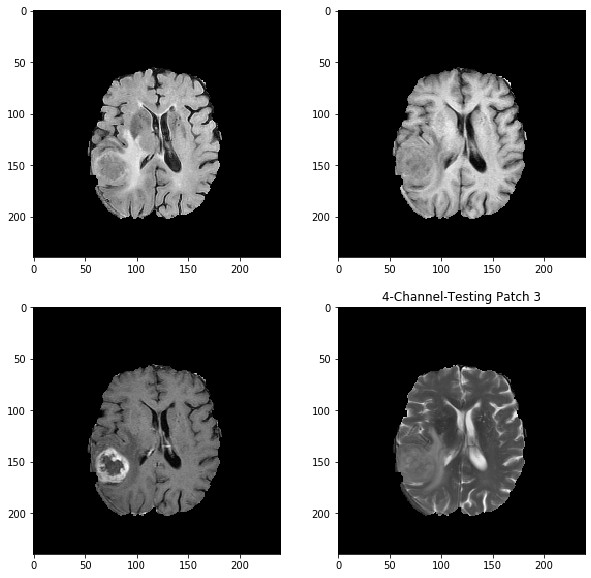

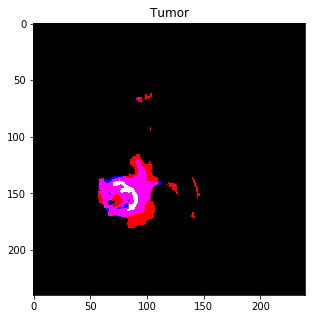

In [66]:
test_segmentation(3)

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


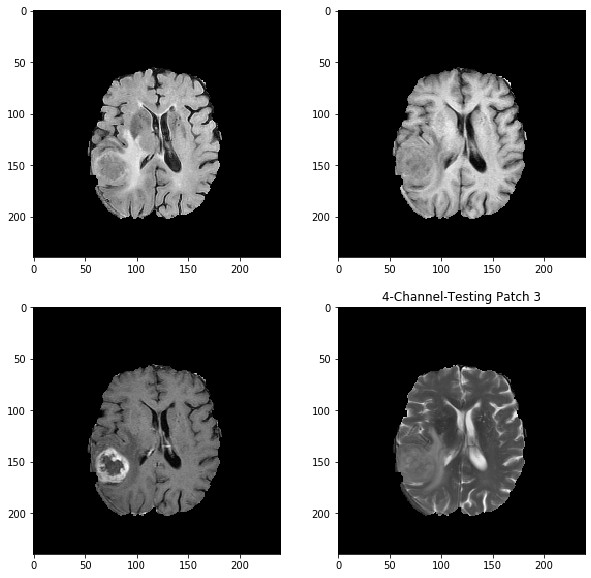

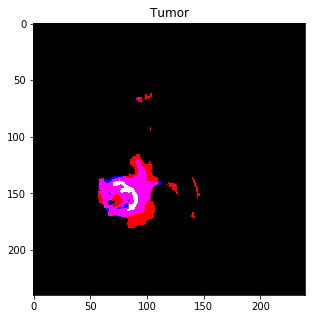

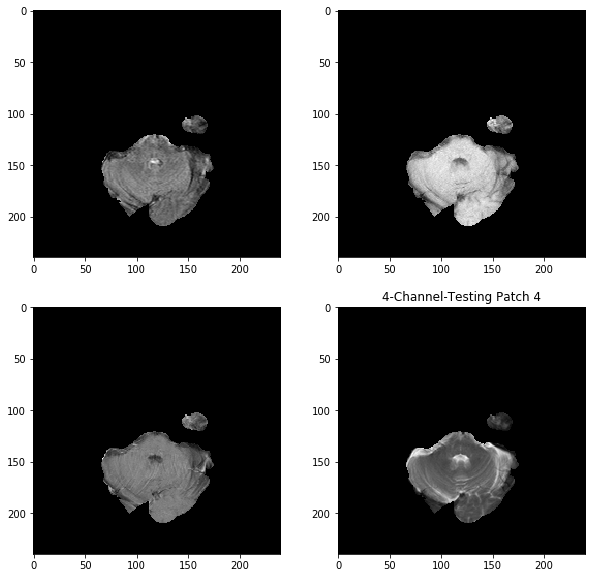

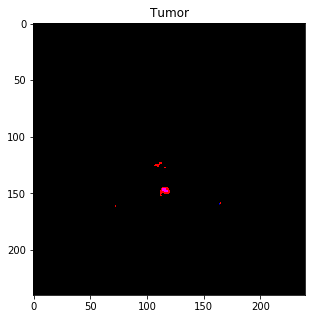

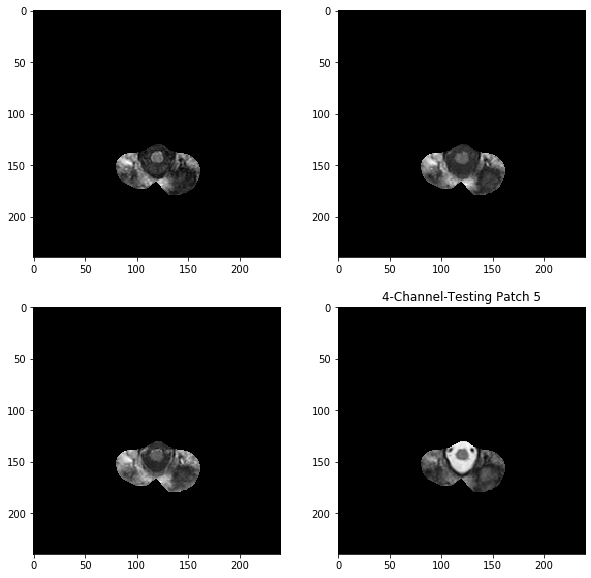

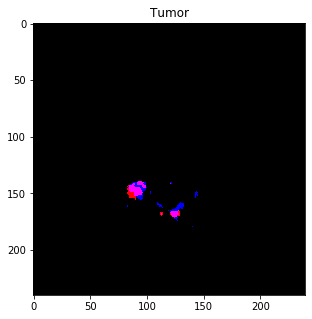

In [69]:
for i in range(3):
    test_segmentation(i+3)
    